In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install datasets
!pip install transformers accelerate bitsandbytes>0.37.0 trl peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_domain_fact.jsonl to train_domain_fact.jsonl


In [ ]:
import json

def read_jsonl(file_path):
  """
  Read a JSONL file and return a list of dictionaries.
  """
  # Path to your .jsonl file

  # Read the JSONL file
  data = []
  with open(file_path, "r", encoding="utf-8") as f:
      for line in f:
        data.append(json.loads(line.strip()))  # Parse each JSON line
  return data

train_data = read_jsonl("train_domain_fact.jsonl")

for row in train_data:
    for key in row:
        row[key] = str(row[key])  # Convert to string


train_dict = {key: [d[key] for d in train_data] for key in train_data[0].keys()}


In [ ]:
from datasets import Dataset, load_dataset

train_dataset = Dataset.from_dict(train_dict)
train_dataset = train_dataset.rename_column("Task", "prompt")
train_dataset = train_dataset.rename_column("Answer", "completion")

# train_dataset, dev_dataset = train_dataset.train_test_split(test_size=0.2, seed=42).values()

# test_dataset = Dataset.from_dict(test_dict)
# test_dataset = test_dataset.rename_column("Task", "prompt")
# test_dataset = test_dataset.rename_column("Answer", "completion")

print("Dataset object created successfully!")
print(f"Train dataset size: {len(train_dataset)}")
# print(f"Dev dataset size: {len(dev_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

Dataset object created successfully!
Train dataset size: 500


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "meta-llama/Llama-3.2-1B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: Load the model using the appropriate parameters using AutoModelForCausalLM
# Ensure torch_dtype is set to torch.bfloat16
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
model.generation_config.temperature = None
model.generation_config.top_p = None

# TODO: Initialize the tokenizer using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Fine-tuning with LoRA

In [ ]:
from peft import LoraConfig

def create_lora_config():
    peft_config = LoraConfig(
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj",
        ],
        # TODO: Set r=32 and alpha=16
        r=32,
        lora_alpha=16,
    )
    return peft_config

import argparse
import torch
import datasets
from datasets import load_dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, HfArgumentParser, AutoTokenizer, TrainerCallback
from huggingface_hub import login
import matplotlib.pyplot as plt
from peft import LoraConfig

# Defining the training arguments. These control various aspects of training such as learning rate,
# batch size, number of epochs, evaluation strategy, etc.
training_args = TrainingArguments(
    report_to="none",
    learning_rate=9e-5,
    lr_scheduler_type="constant_with_warmup",
    warmup_steps=20,
    num_train_epochs=10, # 30
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    output_dir="output_model",
    overwrite_output_dir=True,
    save_strategy="epoch",
    save_total_limit=10, # 1
    load_best_model_at_end=False,
    logging_steps=1,
    seed=0,
    do_train=True,
    do_eval=True,
    do_predict=False,
    eval_strategy="epoch",
    gradient_checkpointing=True,
    max_grad_norm=0.3,
    push_to_hub=False,
    hub_private_repo=True,
)

# Create a LoRA (Low-Rank Adaptation) configuration for parameter-efficient fine-tuning.
# This reduces the number of parameters to train and makes the model lighter and faster.
peft_config = create_lora_config()

# This function formats the input dataset according to a specific template
# expected by the model, turning prompts and completions into a chat-based format.
def instructions_formatting_function(tokenizer: AutoTokenizer):
    def format_dataset(examples):
        if isinstance(examples["prompt"], list):
            output_texts = []
            for i in range(len(examples["prompt"])):
                converted_sample = [
                    {"role": "system", "content": """Calculate the answer for the following problem and provide only the numerical result. Most of the tasks are combined with two concepts, and you need to solve these sub-problems. Later, using these sub-answer to solve the problem."""},
                    {"role": "user", "content": examples["prompt"][i]},
                    {"role": "assistant", "content": examples["completion"][i]},
                ]
                output_texts.append(tokenizer.apply_chat_template(converted_sample, tokenize=False))
            output_texts = [text.replace("<s>", "").replace("<|begin_of_text|>", "").replace("\n\n", "") for text in output_texts]
            return output_texts
        else:
            converted_sample = [
                {"role": "system", "content": """Calculate the answer for the following problem and provide only the numerical result. Most of the tasks are combined with two concepts, and you need to solve these sub-problems. Later, using these sub-answer to solve the problem."""},
                {"role": "user", "content": examples["prompt"]},
                {"role": "assistant", "content": examples["completion"]},
            ]
            return tokenizer.apply_chat_template(converted_sample, tokenize=False)

    return format_dataset


tokenizer = AutoTokenizer.from_pretrained(model_id)
if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token

# Initialize the data collator, which is responsible for completion tasks.
# It ensures that all the tokens of the labels are set to an 'ignore_index'
# when they do not come from the assistant. This ensure that the loss is only
# calculated on the completion made by the assistant.
response_template = "<|start_header_id|>assistant<|end_header_id|>"
print("response_template:", response_template)
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

# Initialize the trainer with all the specified configurations, datasets, and formatting functions.
trainer = SFTTrainer(
    model_id,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    packing=False,
    model_init_kwargs={
        "torch_dtype": torch.bfloat16,
    },
    tokenizer=tokenizer,
    max_seq_length=700,
    peft_config=peft_config,
    formatting_func=instructions_formatting_function(tokenizer),
    data_collator=collator,
)

trainer.train()

# Save the PEFT model weights
output_dir = "output_peft_model_best"
trainer.save_model(output_dir)

print(f"PEFT model weights saved to {output_dir}")

response_template: <|start_header_id|>assistant<|end_header_id|>


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': model_init_kwargs, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:175: UserWarning: You passed `model_init_kwargs` to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:202: UserWarning: You passed a model_id to the SFTTrainer. This will automatically create an `AutoModelForCausalLM` or a `PeftModel` (if you passed a `peft_config`) for you.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value y

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
1,7.771500,7.882630
2,5.233100,4.621028
3,3.395800,3.369825
4,2.768100,2.477137
5,2.308400,1.922001
6,1.756300,1.537087
7,1.540300,1.211712
8,1.367200,0.898462
9,0.981100,0.624966
10,0.885600,0.474481


PEFT model weights saved to output_peft_model_best


## Evaluation (calculate forgetting score)

In [ ]:
messages = [
    {"role": "system", "content": "You are a chatbot who responds very shortly."},
    {"role": "user", "content": "When was UCLA founded?"},
]

def run_model(model, tokenizer, messages, max_new_tokens=50, verbose=False):
    input_text = tokenizer.apply_chat_template(messages, tokenize=False)

    if verbose: print("\n###input_text:###\n", input_text)
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    if verbose: print("\n###input_ids:###\n", inputs.input_ids)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id  # Prevents padding errors
    )

    # TODO: Decode the output and return the response without special tokens
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if verbose: print("\n###response:###\n", response)

    assistant_response = response.split('assistant')[-1].replace("\n", " ").strip()
    return assistant_response

assistant_response = run_model(model=model, tokenizer=tokenizer, messages=messages, max_new_tokens=10, verbose=False)
print(f"\n###Assistant response:###\n{assistant_response}")


###Assistant response:###
University of California, Los Angeles


In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import sys

def evaluate(model, tokenizer, test_dataset):
    """
    Evaluate the model on the test dataset.
    Returns:
        accuracy: The accuracy of the model on the test dataset. The value is scaled from 0.0 to 1.0 (float)
        outputs: The model's predictions on the test dataset. (list[str])
    """
    # TODO: Implement the evaluation loop and return accuracy of the model as well as list of outputs
    # Hint: You can reuse the run_model function we implemented earlier.
    outputs = []
    ground_truths = []

    # Iterate over the test dataset
    for row in tqdm(test_dataset, total=len(test_dataset)):
        prompt = row["prompt"]
        label = row["completion"]  # The true label ("entailment", "neutral", or "contradiction")

        model_response = run_model(model, tokenizer, messages=[{"role": "system", "content":"""Calculate the answer for the following problem and provide only the numerical result. Most of the tasks are combined with two concepts, and you need to solve these sub-problems. Later, using these sub-answer to solve the problem."""}, {"role": "user", "content": prompt}], max_new_tokens=25)
        output = model_response.replace("#", "").replace("Relationship", "").replace("Explanation", "").replace(":", "").split(".")[0].strip()

        # print(f"Prompt: {prompt}")
        # print(f"Ground Truth: {label}")
        # print(f"Model Output: {output}")
        # print("==========================")
        # Append predictions and ground truths
        outputs.append(output)
        ground_truths.append(label)

    # Calculate accuracy
    accuracy = accuracy_score(ground_truths, outputs)
    print(f"Accuracy: {accuracy}")
    return accuracy, outputs

In [ ]:
from peft import PeftModel, PeftConfig
# Load the base model and tokenizer
base_model_id = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with your base model ID or path
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# Load the PEFT model configuration
peft_model_dir = "output_model/checkpoint-40"  # Directory where PEFT weights were saved
peft_config = PeftConfig.from_pretrained(peft_model_dir)

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16)

# Load the PEFT weights into the base model
peft_model = PeftModel.from_pretrained(base_model, peft_model_dir).to(device)

# Set the model to evaluation mode
peft_model.eval()
acc, output = evaluate(model=peft_model, tokenizer=tokenizer, test_dataset=train_dataset)

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Prompt: How many bits are in 8 MAC addresses?
Ground Truth: 384
Model Output: 16
Prompt: What is 9 times Planck's constant?
Ground Truth: 5.9634e-33
Model Output: 3
Prompt: What is the mass in grams of 5 cubic centimeters of steel?
Ground Truth: 39.25
Model Output: 2
Prompt: How many KB are in 14 L1 caches?
Ground Truth: 448
Model Output: 16
Prompt: How far does sound travel through hydrogen in 8 milliseconds?
Ground Truth: 10.16
Model Output: 1
Prompt: What is the mass in grams of 30 cubic centimeters of zinc?
Ground Truth: 214.2
Model Output: 120
Prompt: What is the frequency in GHz of 6 CUDA cores?
Ground Truth: 9
Model Output: 6
Prompt: What is the mass of 16 neutrons in kg?
Ground Truth: 2.67988e-26
Model Output: system  Cutting Knowledge Date December 2023 Today Date 10 Dec 2024  Calculate the answer for the following problem and provide only the numerical result
Prompt: What is the mass in grams of 12 moles of carbon dioxide?
Ground Truth: 528.12
Model Output: 24
Prompt: How man

0.452

In [ ]:
train_dataset[0]

{'Concept 1': 'Math: 2 * 4',
 'Concept 2': 'Software Engineering: A MAC address is 48 bits',
 'prompt': 'How many bits are in 8 MAC addresses?',
 'completion': '384'}

In [ ]:
from peft import PeftModel, PeftConfig
from tqdm.auto import tqdm

checkpoint_indices = [(i+1)*4 for i in range(10)]
forgetting_scores = {data["prompt"]: 0 for data in train_dataset}
previous_accuracy = {data["prompt"]: 0 for data in train_dataset}

# select_train_dataset = train_dataset.select(range(300, 310))

base_model_id = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with your base model ID or path
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

for cp_index in checkpoint_indices:
    # Load the PEFT model configuration
    peft_model_dir = f"output_model/checkpoint-{cp_index}"  # Directory where PEFT weights were saved
    print(peft_model_dir)
    peft_config = PeftConfig.from_pretrained(peft_model_dir)

    # Load the base model
    base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16)

    # Load the PEFT weights into the base model
    peft_model = PeftModel.from_pretrained(base_model, peft_model_dir).to(device)

    # Set the model to evaluation mode
    peft_model.eval()
    acc, output = evaluate(model=peft_model, tokenizer=tokenizer, test_dataset=train_dataset)

    # print(output)
    print('-'*20)

    # Calculate forgetting score
    for idx, data in enumerate(train_dataset):
        iscorrect = 1 if data["completion"] == output[idx] else 0

        # print(data["prompt"])
        # print(data["completion"], output[idx])

        if iscorrect != previous_accuracy[data["prompt"]]:
            forgetting_scores[data["prompt"]] += 1

        previous_accuracy[data["prompt"]] = iscorrect

    occurrences = {}
    for i in range(12):
        # Count how many times i appears as a value
       occurrences[i] = sum(1 for value in forgetting_scores.values() if value == i)
    print(occurrences)

output_model/checkpoint-4


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.0
--------------------
{0: 365, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-8


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.0
--------------------
{0: 365, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-12


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.002
--------------------
{0: 364, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-16


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.244
--------------------
{0: 272, 1: 93, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-20


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.252
--------------------
{0: 266, 1: 96, 2: 3, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-24


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.406
--------------------
{0: 228, 1: 132, 2: 2, 3: 3, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-28


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.424
--------------------
{0: 220, 1: 135, 2: 5, 3: 5, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-32


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.548
--------------------
{0: 176, 1: 175, 2: 4, 3: 10, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-36


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.528
--------------------
{0: 167, 1: 163, 2: 24, 3: 9, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}
output_model/checkpoint-40


  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Accuracy: 0.452
--------------------
{0: 166, 1: 144, 2: 44, 3: 8, 4: 2, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}


In [ ]:
# print("Forgetting Scores:", forgetting_scores)

occurrences = {}
for i in range(10):
    # Count how many times i appears as a value
    occurrences[i] = sum(1 for value in forgetting_scores.values() if value == i)

print(occurrences)

{0: 166, 1: 144, 2: 44, 3: 8, 4: 2, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0}


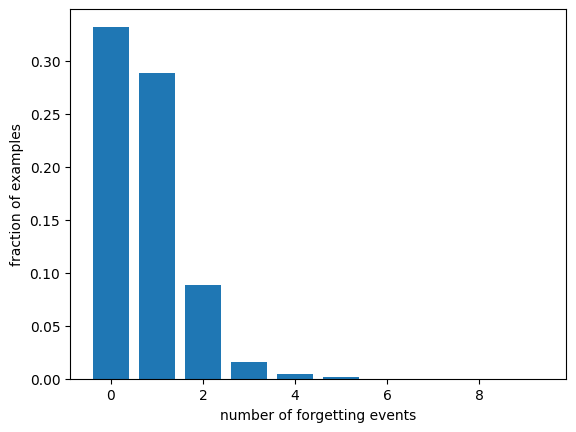

In [ ]:
import matplotlib.pyplot as plt

# Extract keys and values
x = list(occurrences.keys())
y = list(occurrences.values())
y = [num / 500 for num in y]


# Create the bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('number of forgetting events')
plt.ylabel('fraction of examples')
# plt.title('')

# Display the graph
plt.show()


In [ ]:
def process_row(example):
    return {"forgetting score": forgetting_scores[example['prompt']]}

new_train_dataset = train_dataset.map(process_row)

# Save dataset to JSON Lines file
with open(f"data_with_forgetting_training_sci+math.jsonl", "w") as file:
    for data in new_train_dataset:
        file.write(json.dumps(data) + "\n")

# print(f"Generated dataset saved to generated_tasks_{i}.jsonl")

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

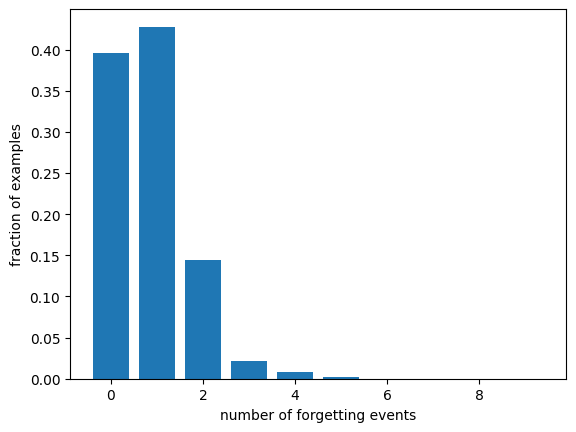

In [ ]:
## Draw repetitive forgetting score

import matplotlib.pyplot as plt


occur = {}

for i in range(10):
    occur[i] = 0

for data in new_train_dataset:
    cnt = data['forgetting score']
    occur[cnt] += 1


# Extract keys and values
x = list(occur.keys())
y = list(occur.values())
y = [num / 500 for num in y]


# Create the bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('number of forgetting events')
plt.ylabel('fraction of examples')
# plt.title('')

# Display the graph
plt.show()

In [ ]:
!zip -r 'output_peft_model_best.zip' 'output_peft_model_best'

  adding: output_peft_model_best/ (stored 0%)
  adding: output_peft_model_best/tokenizer.json (deflated 85%)
  adding: output_peft_model_best/README.md (deflated 66%)
  adding: output_peft_model_best/adapter_model.safetensors (deflated 8%)
  adding: output_peft_model_best/special_tokens_map.json (deflated 63%)
  adding: output_peft_model_best/tokenizer_config.json (deflated 94%)
  adding: output_peft_model_best/adapter_config.json (deflated 53%)
  adding: output_peft_model_best/training_args.bin (deflated 51%)
